In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(0.33/np.pi)
r2 = np.sqrt((0.33/np.pi+r1**2))
r1, r2

(0.32410224072142874, 0.4583497844237541)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [10]:
%%time
path_figs = './figs/2Mstd5/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 0 ns, sys: 822 µs, total: 822 µs
Wall time: 1.07 ms


In [11]:
%%time

N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000
CPU times: user 1.46 s, sys: 504 ms, total: 1.96 s
Wall time: 2.05 s


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492
2,0.423655,0.645894,2,0,-1.354279,-0.796995,0.557284
3,0.437587,0.891773,0,1,5.268565,7.564383,-2.295817
4,0.963663,0.383442,0,0,-10.479152,0.651748,11.130900


In [13]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,4.997836e-01,5.001988e-01,1.141471e+00,5.001005e-01,1.200059e+00,1.206831e+00,1.139937e+00
std,2.887267e-01,2.886267e-01,1.719710e+00,5.000001e-01,5.131388e+00,5.127597e+00,7.274753e+00
min,1.637144e-07,2.516784e-08,0.000000e+00,0.000000e+00,-2.474868e+01,-2.359529e+01,-3.482132e+01
25%,2.495544e-01,2.502948e-01,0.000000e+00,0.000000e+00,-2.267743e+00,-2.258883e+00,-3.781478e+00
50%,4.999703e-01,5.003810e-01,0.000000e+00,1.000000e+00,1.182992e+00,1.188851e+00,1.113156e+00
75%,7.499998e-01,7.500191e-01,2.000000e+00,1.000000e+00,4.644806e+00,4.655453e+00,6.031475e+00
max,9.999993e-01,9.999997e-01,5.000000e+00,1.000000e+00,2.764246e+01,2.584013e+01,3.583212e+01


In [14]:
data['C'].value_counts()/len(data)

0    0.629252
5    0.078920
4    0.078807
3    0.078780
1    0.073178
2    0.061063
Name: C, dtype: float64

In [15]:
data.groupby('C').ITE.mean()

C
0    0.000688
1    0.982160
2    2.003933
3    2.989639
4    4.016455
5    4.982482
Name: ITE, dtype: float64

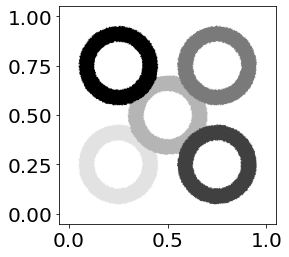

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [17]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [18]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 1h 4min 13s, sys: 2.45 s, total: 1h 4min 15s
Wall time: 1h 4min 16s


In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337,1,1.505433,-7.684466
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492,0,1.045574,-2.712437
2,0.423655,0.645894,2,0,-1.354279,-0.796995,0.557284,1,5.643710,6.997989
3,0.437587,0.891773,0,1,5.268565,7.564383,-2.295817,0,2.651884,2.616681
4,0.963663,0.383442,0,0,-10.479152,0.651748,11.130900,0,1.506943,11.986095


### Model performance

In [20]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        1.003019  1.007931  1.072812  0.004912  0.069793
            1        0.996061  0.977450  1.073086 -0.018611  0.077024
          1 0        0.014185  1.004158  1.006925  0.989973  0.992740
            1       -0.017873  1.066829  1.006235  1.084702  1.024107
          2 0       -0.029741  2.029716  1.928337  2.059457  1.958078
            1       -0.019285  1.985185  1.926751  2.004469  1.946036
          3 0        0.022727  2.988244  2.830213  2.965517  2.807486
            1       -0.065320  3.040098  2.833210  3.105418  2.898530
          4 0       -0.000843  4.022746  3.838305  4.023589  3.839148
            1        0.025607  3.945899  3.836959  3.920292  3.811352
          5 0        0.004174  5.036777  4.789187  5.032603  4.785013
            1        0.042867  4.964561  4.799675  4.921694  4.756808
1         0 0        1.004904  1.002898  0.929440  0.002006  0.075464
            1        1.002823  1.005095  0.936726 -0.002272  0.066097
          1 0        0.977054  0.011221  0.131186  0.965834  0.845869
            1        0.943217  0.029556  0.137547  0.913661  0.805670
          2 0        1.975536  0.014593  0.101209  1.960943  1.874327
            1        2.022097  0.068924  0.098205  1.953174  1.923892
          3 0        2.986992  0.005630  0.154767  2.981363  2.832226
            1        2.991202 -0.010284  0.147832  3.001485  2.843369
          4 0        4.020679 -0.000282  0.121989  4.020961  3.898690
            1        4.035872 -0.030161  0.116300  4.066033  3.919572
          5 0        4.979136  0.041450  0.119034  4.937686  4.860102
            1        5.008861 -0.012104  0.120379  5.020965  4.888482

### Apply clustering Box and Kmeans

In [21]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 19h 42min 11s, sys: 1h 32min 22s, total: 21h 14min 33s
Wall time: 1h 39min 18s


In [22]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337,1,1.505433,-7.684466,982,675
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492,0,1.045574,-2.712437,762,203
2,0.423655,0.645894,2,0,-1.354279,-0.796995,0.557284,1,5.643710,6.997989,866,271
3,0.437587,0.891773,0,1,5.268565,7.564383,-2.295817,0,2.651884,2.616681,1200,1166
4,0.963663,0.383442,0,0,-10.479152,0.651748,11.130900,0,1.506943,11.986095,553,459


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [23]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [24]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.493584,1409.0,1.0,0.000705
1,1,-0.134775,1451.0,1.0,0.000726
2,2,0.101705,1399.0,1.0,0.000700


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


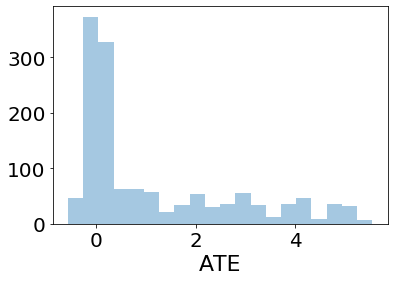

In [25]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 20
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, bins=bins, kde = False,ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


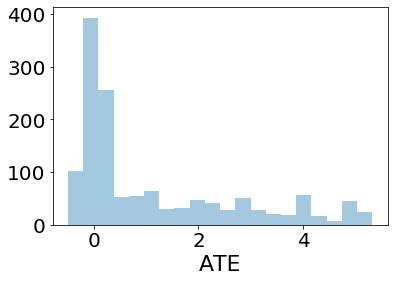

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], 
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


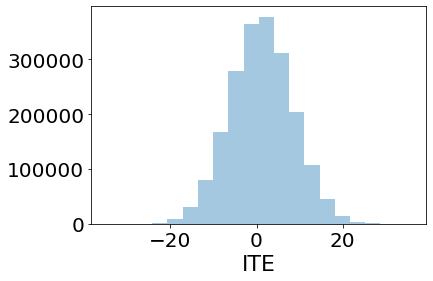

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = bins,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [28]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,1369.00000,1369.000000,1369.000000,1369.000000,1369.000000
mean,684.00000,1.140851,1460.920380,0.940551,0.000730
std,395.34057,1.591278,37.097551,0.123603,0.000019
min,0.00000,-0.568459,1345.000000,0.486869,0.000673
25%,342.00000,-0.001516,1435.000000,0.977417,0.000718
50%,684.00000,0.237891,1460.000000,1.000000,0.000730
75%,1026.00000,2.118260,1486.000000,1.000000,0.000743
max,1368.00000,5.550324,1590.000000,1.000000,0.000795


### Calculate ATT per Cluster not known Model Calculated CF

In [29]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


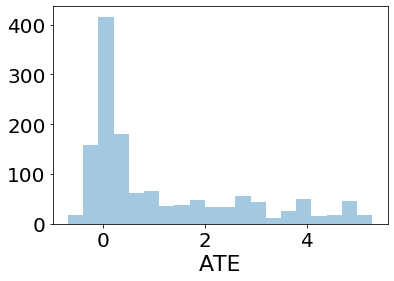

In [30]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'],bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-0.5,2.5)
if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


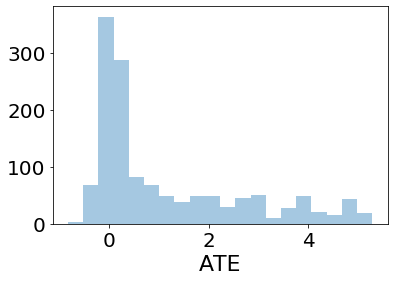

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], 
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-1,2.5)
if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


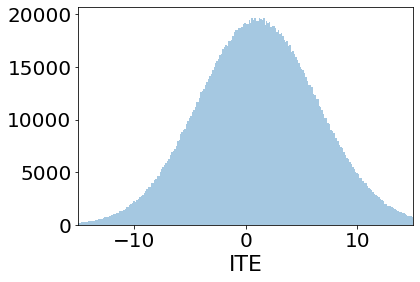

In [32]:
fig, ax = plt.subplots(1,1)
bins = 400
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ITE')
#ax.set_ylabel('weight')
ax.set_xlim(-15,15)
if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [33]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 7
val = 6
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N, val = val )
    


Did not pick 6, it picked: 7
Did not pick 6, it picked: 7
Did not pick 6, it picked: 7
Did not pick 6, it picked: 7
CPU times: user 1.18 s, sys: 81.7 ms, total: 1.26 s
Wall time: 2.08 s


In [34]:
box['Box-Cl2'].value_counts()

0    785
1    157
3    129
2    126
4     92
5     80
Name: Box-Cl2, dtype: int64

In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.493584,1409.0,1.0,0.000705,0
1,1,-0.134775,1451.0,1.0,0.000726,0


In [36]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337,1,1.505433,-7.684466,982,675
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492,0,1.045574,-2.712437,762,203


### 3 Clustering in the ITEs

In [37]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5
filt41 = data2[col1] >= 2.5
filt51 = data2[col1] >= 3.5
filt61 = data2[col1] >= 4.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2
data2.loc[filt41,cluster_name1] = 3
data2.loc[filt51, cluster_name1] = 4
data2.loc[filt61, cluster_name1] = 5

cluster_name2 = 'ITE-2CGDBR'
col2 = 'ITE-GDBR'
filt12 = data2[col2] <= 0.5
filt22 = data2[col2] >= 0.5
filt32 = data2[col2] >= 1.5
filt42 = data2[col2] >= 2.5
filt52 = data2[col2] >= 3.5
filt62 = data2[col2] >= 4.5


data2[cluster_name2] = 0
data2.loc[filt12,cluster_name2] = 0
data2.loc[filt22, cluster_name2] = 1
data2.loc[filt32, cluster_name2] = 2
data2.loc[filt42,cluster_name2] = 3
data2.loc[filt52, cluster_name2] = 4
data2.loc[filt62, cluster_name2] = 5


#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [38]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337,1,1.505433,-7.684466,982,675,0,0,1,1,2,2
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492,0,1.045574,-2.712437,762,203,2,0,1,1,1,1


### Plot reconstruction of data

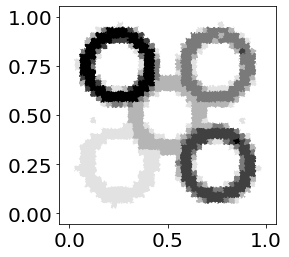

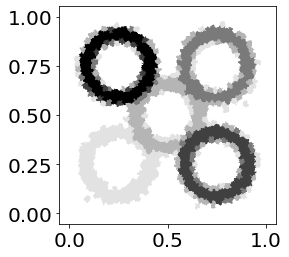

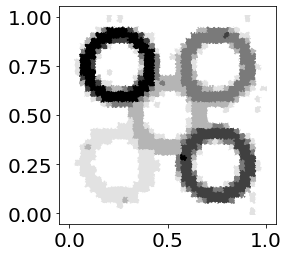

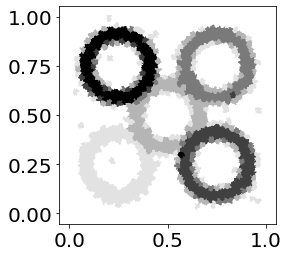

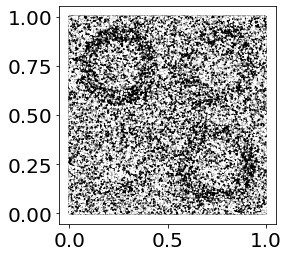

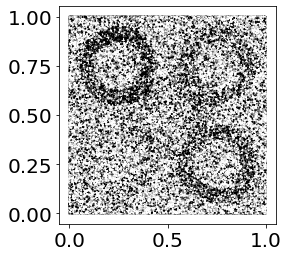

CPU times: user 9min 49s, sys: 15.7 s, total: 10min 5s
Wall time: 9min 46s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [41]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [42]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [43]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [44]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [45]:
errors.sort_values(by = 'mean')

,mean,std
Box-Cl2-err-True-ITE,0.261309,0.643348
Kmeans-Cl2-err-True-ITE,0.271827,0.651719
Box2-Cl2-err-True-ITE,0.293191,0.640121
Kmeans2-Cl2-err-True-ITE,0.295940,0.650724
Box-Cl2-err-GDBR,0.306777,0.625260
Kmeans-Cl2-err-GDBR,0.314023,0.634582
Box2-Cl2-err-GDBR,0.325044,0.626840
Kmeans2-Cl2-err-GDBR,0.327589,0.637333
ITE-2CTrue-err-GDBR,2.945454,1.700809
ITE-2CGDBR-err-True-ITE,3.943051,2.057439


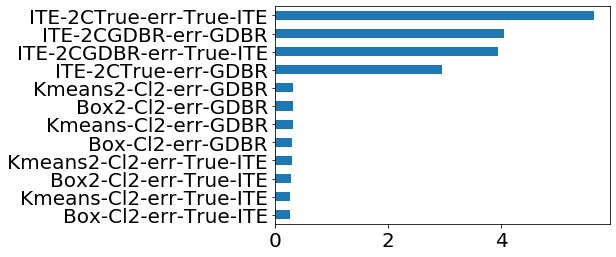

In [46]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [47]:
from evaluations import confusion_matrix
    

In [48]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name, 6, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.893198,0.059681,0.028203,0.014825,0.003603,0.000489
C1 True,0.112930,0.871040,0.016029,0.000000,0.000000,0.000000
C2 True,0.015820,0.079360,0.837030,0.061395,0.003226,0.003169
C3 True,0.014693,0.059882,0.162307,0.753991,0.009127,0.000000
C4 True,0.008622,0.025213,0.072849,0.179343,0.704855,0.009117
C5 True,0.008401,0.022548,0.041998,0.096522,0.104498,0.726033


Kmeans-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.873133,0.070885,0.039448,0.012232,0.003852,0.000449
C1 True,0.073239,0.909747,0.017013,0.000000,0.000000,0.000000
C2 True,0.009073,0.130905,0.794968,0.059373,0.005527,0.000156
C3 True,0.011247,0.054805,0.176994,0.756955,0.000000,0.000000
C4 True,0.002855,0.026032,0.105403,0.113664,0.752046,0.000000
C5 True,0.005531,0.020280,0.066536,0.076387,0.114261,0.717005


Box2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.850471,0.092430,0.033118,0.019569,0.003923,0.000489
C1 True,0.085729,0.876267,0.038003,0.000000,0.000000,0.000000
C2 True,0.009818,0.073145,0.822906,0.087737,0.003226,0.003169
C3 True,0.010352,0.030953,0.165176,0.784309,0.009209,0.000000
C4 True,0.007677,0.019973,0.053288,0.196074,0.713547,0.009441
C5 True,0.003605,0.019298,0.037494,0.102217,0.111353,0.726033


Kmeans2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.839421,0.098082,0.044643,0.012894,0.004304,0.000656
C1 True,0.060797,0.915747,0.023457,0.000000,0.000000,0.000000
C2 True,0.006133,0.129717,0.788998,0.069469,0.005494,0.000188
C3 True,0.003751,0.049454,0.164408,0.772631,0.009755,0.000000
C4 True,0.001980,0.020150,0.097288,0.136301,0.734446,0.009834
C5 True,0.002807,0.015402,0.079226,0.059757,0.116808,0.726001


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.528663,0.055644,0.053846,0.051456,0.048231,0.262160
C1 True,0.474159,0.055973,0.055146,0.054354,0.052236,0.308132
C2 True,0.415666,0.055672,0.056245,0.055131,0.054206,0.363081
C3 True,0.362194,0.053923,0.056474,0.056804,0.055440,0.415165
C4 True,0.309934,0.051829,0.052863,0.056258,0.055503,0.473613
C5 True,0.263349,0.048790,0.051888,0.053516,0.055784,0.526673


ITE-2CGDBR


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.533769,0.076619,0.072690,0.066354,0.058594,0.191973
C1 True,0.467477,0.079361,0.077086,0.072160,0.065942,0.237975
C2 True,0.389504,0.077894,0.079262,0.077354,0.072122,0.303864
C3 True,0.322876,0.073833,0.077952,0.078548,0.076244,0.370547
C4 True,0.252249,0.067456,0.073052,0.078749,0.078242,0.450252
C5 True,0.197713,0.060295,0.067043,0.072776,0.077350,0.524823


In [49]:
data2.groupby('ITE-2CGDBR').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.495586,0.491476,0.693993,0.500060,1.075918,1.090380,-3.395831,0.199650,1.067666,-3.509194,672.176629,682.019413,0.820134,0.751777,0.771607,0.804726,0.808195,0.267736,0.275838,0.286482,0.288604,2.724937,4.203187,0.227445,0.238784,0.260010,0.262139,5.311895,4.089824
1,0.500696,0.497187,1.042308,0.501048,1.172404,1.166066,0.996291,0.198754,1.170428,0.999692,680.183721,681.948364,1.937469,1.054428,1.070713,1.109305,1.108856,0.300707,0.307596,0.319585,0.321320,2.991853,1.333610,0.256664,0.266884,0.289334,0.291313,5.404695,1.332619
2,0.501199,0.498807,1.133721,0.502122,1.200143,1.204161,1.959507,0.202205,1.190780,1.996715,682.410997,682.996029,2.299800,1.134395,1.151150,1.190756,1.190225,0.308937,0.314771,0.329026,0.330413,3.065709,1.778405,0.263814,0.272950,0.297586,0.299331,5.501722,1.763527
3,0.503883,0.498662,1.242335,0.501831,1.237520,1.249601,2.920584,0.200916,1.227431,2.994450,682.322369,681.628221,2.663381,1.230188,1.246055,1.285664,1.283060,0.317875,0.325679,0.337939,0.339906,3.149683,2.261269,0.271470,0.282629,0.305178,0.307465,5.645751,2.225739
4,0.503099,0.503175,1.348921,0.500660,1.262170,1.249288,3.905115,0.200646,1.257420,3.992468,688.477337,680.824875,3.030151,1.321574,1.338149,1.376656,1.376431,0.324334,0.329390,0.342976,0.344186,3.208963,2.836067,0.276525,0.284935,0.308827,0.310331,5.799527,2.782013
5,0.504489,0.516215,1.868376,0.498740,1.397497,1.398862,7.648660,0.199941,1.425330,7.786539,706.342850,680.435756,4.042313,1.775036,1.784777,1.829702,1.823042,0.368192,0.374843,0.384381,0.388691,3.161373,5.918163,0.314089,0.324004,0.343452,0.348198,6.224999,5.780284


In [50]:
np.mean(np.abs(data2['C'] - data2['ITE-GDBR'])), np.std(np.abs(data2['C'] - data2['ITE-GDBR']))

(4.056349828176499, 3.066555384529081)